***
#### Importing necessary libraries

In [1]:
from qiskit import QuantumCircuit, transpile
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit.visualization import plot_histogram

from qiskit_ibm_runtime import QiskitRuntimeService

> Note: You must run this cell before running any other cells in this notebook.
***

# IBM Quantum Demo
***
In this notebook I will go through the process of using the IBM Quantum Platform using Qiskit. 

> Note: This guide was created July 2024 and it is possible the IBM Quantum Platform API specification has changed since then.

## Obtaining an API Token
It is possible for anyone to obtain an API token to for the IBM Quantum Platform. Follow the steps below to do so:
1. Go to [IBM Quantum](https://www.ibm.com/quantum) and click *Sign in to Platform* in the top right.
2. Under the prompt *New to IBM Quantum?* click the link *Create an IBMid*.
3. Follow the steps to create an IBMid.
4. Once you have obtained an IBMid you will be able to sign into IBM Quantum Platform.
5. Your API token can be found on the top right of your dashboard.

## Adding Your API Token
To use the IBM Quantum Platform API you must first get your API token and added it to the project. For security I have excluded my API token from the contents of this Git repository but will walk you though adding yours here.
1. On the dashboard of the IBM Quantum Platform you will find your API token in the top right.
2. In the directory of this notebook create a text file named *API_KEYS.txt*.
3. Copy the token and paste it in the [API_KEYS.txt](API_KEYS.txt) file with "IBM_QUANTUM =" preceding it.
4. The contents of this file should look like "IBM_QUANTUM = YOUR_TOKEN_HERE" with your token in place of "YOUR_TOKEN_HERE".
5. Save and close the file.  
6. Run the code cell below to add your API token to the project.

In [2]:
keys = open('API_KEYS.txt', 'r').read().splitlines()
for key in keys:
    if key.startswith('IBM_QUANTUM'):
        IBM_QUANTUM_API_KEY = key.split(' = ')[1]
        break

## Testing the API Token
The basic piece of code below will test if you have added your API Token correctly.

### Create a basic circuit

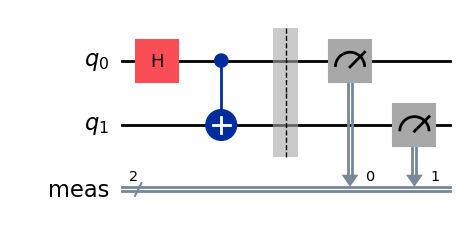

In [3]:
# Create a quantum circuit that prepares a Bell state.
qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0, 1)
qc.measure_all()

# Draw the circuit.
qc.draw('mpl')


### Test the circuit with a fake backend

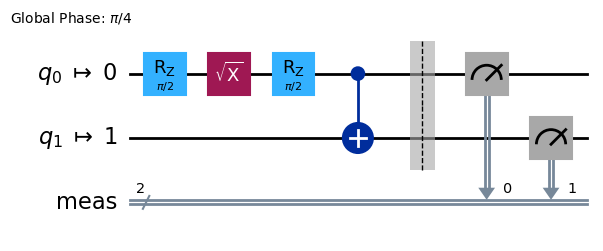

In [4]:
# Generate a 2 qubit simulated backend.
backend = GenericBackendV2(num_qubits = 2)

# Transpile the circuit using the backend.
transpiled_qc = transpile(qc, backend)
transpiled_qc.draw('mpl')

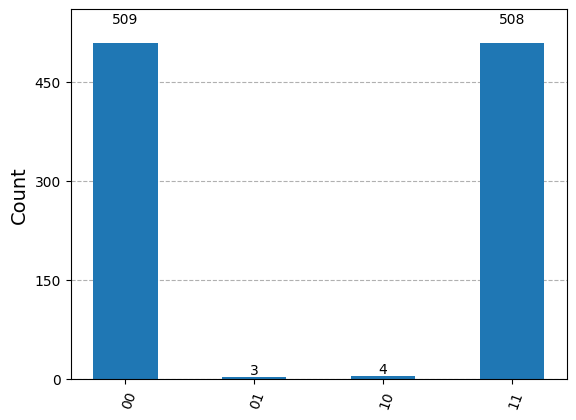

In [5]:
# Run the transpiled circuit using the simulated backend.
job = backend.run(transpiled_qc)
counts = job.result().get_counts()
plot_histogram(counts)